In [1]:
# Warning: Execute this cell only once for the kernel. Reset the kernel if you need changes.
import sys
import ROOT as R
import time
import numpy as np
import xgboost as xgb
import pandas as pd
import os
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline
# Turn jsroot off if you want to make a pdf from this file.
%jsroot off
R.gSystem.Load("libMiniDst")
from root_helpers import SetStyle
#R.EnableImplicitMT()

Welcome to JupyROOT 6.28/02


In [2]:
muon_df =pd.read_feather("muplus.feather") #read in muon hdf to pandas dataframe
print(f"Number of muon events in data set is {len(muon_df)}")

elec_df = pd.read_feather("electrons_large.feather")
print(f"Number of electron envents in data set is {len(elec_df)}")

Number of muon events in data set is 456616
Number of electron envents in data set is 303723


In [3]:
muon_df[0:100]

,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,pdg_id
0,0.420823,0.496185,333.110657,-42.179264,338.483276,-40.589531,2,0.237149,22,-2,11
1,0.247561,0.316166,185.363876,29.310331,174.644073,36.101917,1,0.247561,11,1,-13
2,0.188735,0.239792,-134.561981,-42.101715,-139.367844,-40.552067,2,0.097026,-14,-2,-13
3,0.332808,0.440965,304.757080,-28.434359,298.138702,-29.613213,2,0.204439,20,-1,-13
4,0.146460,0.214402,345.612549,70.604927,331.011536,84.421089,2,0.106964,22,4,22
...,...,...,...,...,...,...,...,...,...,...,...
95,0.168204,0.199832,-254.006302,84.367714,-260.842773,84.812813,3,0.086094,-22,5,22
96,0.217507,0.326472,45.021240,29.299788,33.544285,34.920372,2,0.176984,1,1,-13
97,0.213956,0.280499,185.363876,42.984776,173.908875,50.527584,1,0.213956,11,2,-13
98,0.185995,0.259533,345.772797,43.089863,334.110687,54.197628,2,0.132359,22,2,-13


In [4]:

elec_filt = elec_df.loc[elec_df['pdg_id']==11]
mup_filt = muon_df.loc[muon_df['pdg_id']==-13]



#add column [pdg] for particle identification 
#muon_df['pdg_id'] = pd.Series([13 for x in range(len(muon_df.index))])
#elec_df['pdg_id'] = pd.Series([11 for x in range(len(elec_df.index))])
#verify id column with constant value

#split dfs into two for training and validation. 60% training, 40% validation for now
#muon_short = muon_df.iloc[0:]
#elec_short = elec_df.iloc[0:]
#muon_df_training = muon_df.iloc[0:30000]
#muon_df_validation = muon_df.iloc[30000:50000]
#elec_df_training = elec_df.iloc[0:200000]
#elec_df_validation = elec_df.iloc[200000:]


#print(f"Number of muon events for training: {len(muon_df_training)}")
#print(f"Number of muon events for validation: {len(muon_df_validation)}")
#print(f"Number of electron events for training: {len(elec_df_training)}")
#print(f"Number of electron events for validation: {len(elec_df_validation)}")

#combine training dataframes:
combined_df = pd.concat([elec_filt, mup_filt], ignore_index=True)
#permute the combined dataframe to randomly mix the indices
#ran_loc = np.random.permutation(len(combined))  
shuffled_df= combined_df.sample(frac = 1)
#make sure shuffled df looks correct
print(f"Number of shuffled events: {len(shuffled_df)}")
shuffled_df.head()
shuffled_df.tail()

#split the shuffled df
shuffled_training_df = shuffled_df.iloc[0:400000]
shuffled_validation_df = shuffled_df.iloc[400000:]

print(f"Number of total shuffled events for training: {len(shuffled_training_df)}")
print(f"Number of total mu+ events: {mup_filt.shape[0]}")
print(f"Number of total e- events: {elec_filt.shape[0]}")
print(f"Number of shuffled events for validation: {len(shuffled_validation_df)}")


Number of shuffled events: 579431
Number of total shuffled events for training: 400000
Number of total mu+ events: 394187
Number of total e- events: 185244
Number of shuffled events for validation: 179431


In [5]:
print(f"ratio of e- to mu+: {elec_filt.shape[0]/mup_filt.shape[0]}")

ratio of e- to mu+: 0.46993939424689296


In [6]:
for col in shuffled_training_df.columns:
    print(col)
#print('Fraction e/mu: {}'.format(len(shuffled_training_df[shuffled_training_df.pdg_id == 11])/(float)(len(shuffled_training_df[shuffled_training_df.pdg_id == 13]) + len(shuffled_training_df[shuffled_training_df.pdg_id == 11]))))    

energy
energy_cor
x
y
x_cor
y_cor
nhits
seed_e
seed_ix
seed_iy
pdg_id


We expect the x and y position to be much more important as a training feature than it is with e-/mu-.

In [7]:
only_ecal_tr_df = shuffled_training_df
only_ecal_val_df = shuffled_validation_df
#necessary to let xgboost know that the pdg_id is a categorical feature
only_ecal_tr_df['pdg_id']=only_ecal_tr_df['pdg_id'].astype('category')
only_ecal_val_df['pdg_id']=only_ecal_val_df['pdg_id'].astype('category')
feature_names = only_ecal_tr_df.columns[0:-1] #drop the pdg_id, as its not a dependent variable
print(feature_names)



Index(['energy', 'energy_cor', 'x', 'y', 'x_cor', 'y_cor', 'nhits', 'seed_e',
       'seed_ix', 'seed_iy'],
      dtype='object')


/tmp/ipykernel_1585/279481383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_ecal_tr_df['pdg_id']=only_ecal_tr_df['pdg_id'].astype('category')
/tmp/ipykernel_1585/279481383.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_ecal_val_df['pdg_id']=only_ecal_val_df['pdg_id'].astype('category')


In [8]:
train = xgb.DMatrix(data=only_ecal_tr_df[feature_names],label=only_ecal_tr_df.pdg_id.cat.codes, #what is .cat.codes??
                    missing=-999.0,feature_names=feature_names)
test = xgb.DMatrix(data=only_ecal_val_df[feature_names],label=only_ecal_val_df.pdg_id.cat.codes,
                   missing=-999.0,feature_names=feature_names)

In [9]:
print('Number of training samples: {}'.format(train.num_row()))
print('Number of testing samples: {}'.format(test.num_row()))

print('\nNumber of electron events in training set: {}'.format(len(np.where(train.get_label())[0])))
print(f"Number of muon events in training set: {400000 - 127762}")
print('\nNumber of electron events in testing set: {}'.format(len(np.where(test.get_label())[0])))
print(f"\nNumber of muon events in testing set: {179431-57482}")
print(f"\ntraining e-/mu+ ratio: {127762/272238}")
print(f"\ntesting e-/mu+ ratio: {57482/121949}")

Number of training samples: 400000
Number of testing samples: 179431

Number of electron events in training set: 127884
Number of muon events in training set: 272238

Number of electron events in testing set: 57360

Number of muon events in testing set: 121949

training e-/mu+ ratio: 0.469302595523035

testing e-/mu+ ratio: 0.4713609787698136


In [10]:
param = {}

# Booster parameters
param['eta']              = .1 # learning rate
param['max_depth']        = 10 # maximum depth of a tree
param['subsample']        = 1 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100 # number of trees to make

In [11]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [12]:
print(booster.eval(test))

[0]	eval-rmse:0.12198364576069227	eval-rmse:0.12198364576069227	eval-rmse:0.12198364576069227


In [13]:
predictions = booster.predict(test)

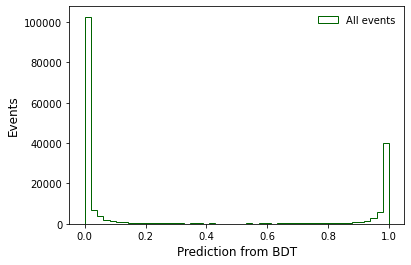

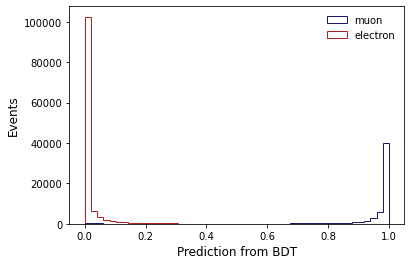

In [14]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='muon');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='electron');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

/tmp/ipykernel_1585/1500798442.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(nsignal/len(only_ecal_val_df[only_ecal_val_df.pdg_id == 11]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


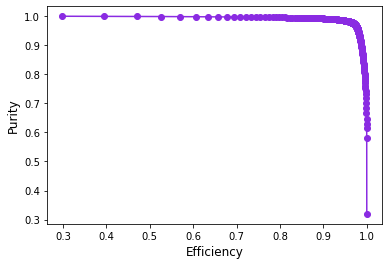

In [15]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[test.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(test.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(only_ecal_val_df[only_ecal_val_df.pdg_id == 11]),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

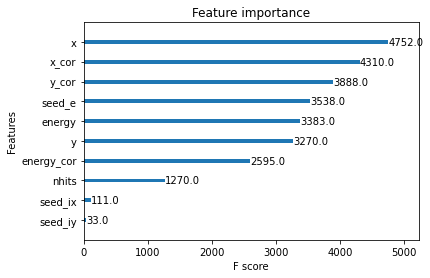

In [16]:
xgb.plot_importance(booster,grid=False);

In [17]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
import time

In [18]:
%%time
X_train = only_ecal_tr_df.drop(columns=['pdg_id']) #remove the 'truth' aka pdg_id column from the features dataset
X_test = only_ecal_val_df.drop(columns=['pdg_id']) #same thing, but for the df for testing the model
Y_train = only_ecal_tr_df['pdg_id'] #this is the df containing the truth values for the X_train features, aka which particle they are
Y_test = only_ecal_val_df['pdg_id'] #contains truth values for the test set 

#check to make sure we have the same number of entries 
X_train.shape[0]==Y_train.shape[0]
#we do the fitting here
clf.fit(X_train, Y_train)
#test the model 
clf.predict(X_test)
X_test.shape
print("Training set score (should be very close to 1): %f" % clf.score(X_train, Y_train))
print("Test set score (how accurate the model is at classifying mu+/e-): %f" % clf.score(X_test, Y_test))
print(f"So using {X_test.shape[0]} datapoints, we on average have a {(1-clf.score(X_test,Y_test))*100} % error")

Training set score (should be very close to 1): 0.999962
Test set score (how accurate the model is at classifying mu+/e-): 0.966188
So using 179431 datapoints, we on average have a 3.381244043671383 % error
CPU times: user 10.6 s, sys: 50.2 ms, total: 10.7 s
Wall time: 10.7 s


In [19]:
X_train.head()

,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy
274142,0.111036,0.164877,354.448883,-28.447832,358.858917,-26.647461,1,0.111036,23,-1
167742,0.905950,1.062832,125.756477,-33.632824,126.334686,-31.725636,6,0.346043,7,-1
76197,2.215500,2.461305,63.033291,45.120964,64.111336,44.578712,7,1.641214,2,2
114250,1.962423,2.254361,-183.047348,-36.252159,-188.166107,-34.462418,6,1.009346,-17,-2
336241,0.168528,0.227479,290.772705,-28.430906,277.748932,-53.201836,2,0.109366,19,-1


In [20]:

A = tree.DecisionTreeClassifier(max_depth=16)

In [21]:

A.fit(X_train, Y_train)
A.predict(X_test)
print(f"So using {X_test.shape[0]} datapoints, we on average have a {(1-A.score(X_test,Y_test))*100} % error")

So using 179431 datapoints, we on average have a 2.803863323505973 % error


In [22]:
predict = A.predict(X_test)
A_score = A.score(X_test,Y_test)

In [23]:
print("Test set score (how accurate the model is at classifying mu+/e-): %f" % A.score(X_test, Y_test))

Test set score (how accurate the model is at classifying mu+/e-): 0.971961


In [24]:
A.feature_importances_

array([8.90696372e-01, 2.39115301e-02, 2.63909241e-02, 8.08557499e-03,
       1.31414211e-02, 2.50494903e-02, 2.77489274e-03, 8.93772676e-03,
       8.82788485e-04, 1.29279345e-04])

In [25]:
from sklearn import metrics
import sklearn

In [26]:
sklearn.metrics.f1_score(Y_test,predict, pos_label = -13)

0.9794121137469463

In [27]:
A.classes_
A.max_features_
A.feature_names_in_
A.feature_importances_

array([8.90696372e-01, 2.39115301e-02, 2.63909241e-02, 8.08557499e-03,
       1.31414211e-02, 2.50494903e-02, 2.77489274e-03, 8.93772676e-03,
       8.82788485e-04, 1.29279345e-04])

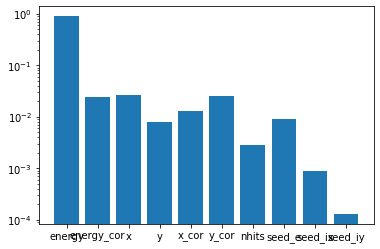

In [28]:
plt.bar(A.feature_names_in_,A.feature_importances_)
plt.yscale('log')

In [29]:
A.classes_


array([-13,  11], dtype=int32)

In [30]:
A.n_outputs_

1

In [31]:
 from sklearn.ensemble import HistGradientBoostingClassifier

In [32]:

hist_gradient_BC = HistGradientBoostingClassifier().fit(X_train,Y_train)

In [33]:
hist_score = hist_gradient_BC.score(X_test,Y_test)

In [34]:
print(f" standard decision tree score: {A_score}, hist gradient score: {hist_score}")

 standard decision tree score: 0.9719613667649403, hist gradient score: 0.9776905885827979


In [35]:
print(f"hist_gradient is {(hist_score - A_score)*100 } % better than the standard classifier")

hist_gradient is 0.5729221817857622 % better than the standard classifier


In [36]:
hist_gradient_BC.decision_function(X_train)

array([-4.10379026,  2.15523272,  4.69143893, ..., -7.07307344,
       -6.39661674,  4.07339695])

In [37]:
emumu_1clus = pd.read_feather("emumu_test.feather")

In [38]:
emumu_1clus.shape

(1409, 11)

In [39]:
#for fun we draw the tree
#tree.plot_tree(clf)

In [40]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data) 
graph.render('mu+_vs_e-_tree') 

KeyboardInterrupt: 